# District-wise Aadhaar Infrastructure Stress Analysis (Karnataka)

**Objective:**  
This notebook performs a district-level analysis of Aadhaar enrolment and update data to identify patterns in service demand, operational load, and infrastructure stress.

## Datasets Used

- Aadhaar enrolment dataset (age-wise counts)
- Aadhaar demographic update dataset
- Aadhaar biometric update dataset

The datasets are sourced from UIDAI and aggregated to the relevant spatial unit (state or district) for analysis.

## Methodology Overview

- Data filtering and aggregation by geographic unit
- Normalization of region names to ensure administrative consistency
- Construction of ratio-based indicators to capture demand intensity
- Spatial visualization using choropleth maps

Redundant metrics were intentionally excluded to maintain interpretability.

In [ ]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
import unicodedata
import re
from rapidfuzz import process, fuzz

BASE_PATH = Path(".")

def load_activity_df(folder_name, activity_label):
    """Load and concatenate all CSV files from a folder."""
    dfs = []
    folder_path = BASE_PATH / folder_name

    for csv_file in folder_path.glob("*.csv"):
        df = pd.read_csv(csv_file)
        df["activity_type"] = activity_label
        df["source_file"] = csv_file.name
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)


def normalize_text(s):
    """Normalize district names by removing accents, lowercasing, and cleaning."""
    if pd.isna(s):
        return None
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("utf-8")
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = s.replace("&", "and")
    return " ".join(s.split())


def build_district_lookup(source_districts, target_districts, threshold=85):
    """Fuzzy match source districts to canonical target districts."""
    lookup = {}
    for d in source_districts:
        match, score, _ = process.extractOne(d, target_districts, scorer=fuzz.token_sort_ratio)
        lookup[d] = match if score >= threshold else None
    return lookup


def plot_choropleth(gdf, column, title, cmap="OrRd", figsize=(8, 8)):
    """Create a choropleth map with consistent styling."""
    ax = gdf.plot(
        column=column,
        cmap=cmap,
        legend=True,
        figsize=figsize,
        edgecolor="black"
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")
    return ax

In [ ]:
BASE_PATH = Path(".")

# load datasets
enrolment_df = load_activity_df("api_data_aadhar_enrolment", "enrolment")
demographic_df = load_activity_df("api_data_aadhar_demographic", "demographic_update")
biometric_df = load_activity_df("api_data_aadhar_biometric", "biometric_update")

# Karnataka only filter
ka_enrolment_df = enrolment_df.loc[enrolment_df["state"] == "Karnataka"].copy()
ka_demographic_df = demographic_df.loc[demographic_df["state"] == "Karnataka"].copy()
ka_biometric_df = biometric_df.loc[biometric_df["state"] == "Karnataka"].copy()

In [ ]:
# geojson read for KA
ka_geo = gpd.read_file("mapKarnataka.json")

In [ ]:
# district name normalization (removing extra spaces, full lwoercase, unicode normalization, etc)
for df in [ka_enrolment_df, ka_demographic_df, ka_biometric_df]:
    df.loc[:, "district_norm"] = df["district"].apply(normalize_text)

ka_geo["district_norm"] = ka_geo["district"].apply(normalize_text)
canonical_districts = ka_geo["district_norm"].unique().tolist()

In [ ]:
# all unique district names from our data (Aadhaar)
all_districts = (
    pd.concat([
        ka_enrolment_df["district_norm"],
        ka_demographic_df["district_norm"],
        ka_biometric_df["district_norm"]
    ])
    .dropna()
    .unique()
)

# fuzzymatch district names to canonical names in the geoJSON found
district_lookup = build_district_lookup(all_districts, canonical_districts, threshold=85)

# manual corrections for mismatches
# Karnataka has a lot of renamed districts (Bangalore→Bengaluru, Belgaum→Belagavi, etc.)
# also the geoJSON found didn't have Vijayanagara in it! (it was made 6 years ago)
manual_map = {
    "bangalore": "bengaluru urban",
    "bangalore rural": "bengaluru rural",
    "bengaluru": "bengaluru urban",
    "bengaluru south": "bengaluru urban",
    "belgaum": "belagavi",
    "bellary": "ballari",
    "bijapur": "vijayapura",
    "gulbarga": "kalaburagi",
    "mysore": "mysuru",
    "shimoga": "shivamogga",
    "chickmagalur": "chikmagalur",
    "bijapur kar": "vijayapura",
    "vijayanagara": "ballari",  # new district from Ballari, 6 year old geojson
}

district_lookup.update(manual_map)

# mapping district names
for df in [ka_enrolment_df, ka_demographic_df, ka_biometric_df]:
    df.loc[:, "district_matched"] = df["district_norm"].map(district_lookup)

In [ ]:
# calculate totals by summing age groups
ka_enrolment_df.loc[:, "enrolment_total"] = (
    ka_enrolment_df["age_0_5"]
    + ka_enrolment_df["age_5_17"]
    + ka_enrolment_df["age_18_greater"]
)

ka_demographic_df.loc[:, "demographic_update_total"] = (
    ka_demographic_df["demo_age_5_17"]
    + ka_demographic_df["demo_age_17_"]
)

ka_biometric_df.loc[:, "biometric_update_total"] = (
    ka_biometric_df["bio_age_5_17"]
    + ka_biometric_df["bio_age_17_"]
)

# district-wise aggregation
district_enrolment = ka_enrolment_df.groupby("district_matched", as_index=False)["enrolment_total"].sum()
district_demo = ka_demographic_df.groupby("district_matched", as_index=False)["demographic_update_total"].sum()
district_bio = ka_biometric_df.groupby("district_matched", as_index=False)["biometric_update_total"].sum()

# merge everything together
district_wide = (
    district_enrolment
    .merge(district_demo, on="district_matched", how="left")
    .merge(district_bio, on="district_matched", how="left")
    .fillna(0)
)

# calculate derived metrics
district_wide["total_updates"] = (
    district_wide["demographic_update_total"] + district_wide["biometric_update_total"]
)

district_wide["total_activity"] = (
    district_wide["enrolment_total"] + district_wide["total_updates"]
)

# UPDATE PRESSURE: updates per enrolment
district_wide["update_pressure"] = (
    district_wide["total_updates"] / district_wide["enrolment_total"]
)

# What fraction of updates are biometric? (indicates infra needs)
district_wide["biometric_infra_intensity"] = (
    district_wide["biometric_update_total"] / district_wide["total_updates"]
)

# Quick look at top districts
print("Top 5 Districts by Total Aadhaar Activity:")
district_wide.sort_values("total_activity", ascending=False).head(5)

Top 5 Districts by Total Aadhaar Activity:


,district_matched,enrolment_total,demographic_update_total,biometric_update_total,total_updates,total_activity,update_pressure,biometric_infra_intensity
4,bengaluru urban,61273,359480,496200,855680,916953,13.965042,0.579890
2,belagavi,14548,117343,190070,307413,321961,21.130946,0.618289
17,kalaburagi,9138,63919,134602,198521,207659,21.724776,0.678024
1,ballari,9120,66471,125555,192026,201146,21.055482,0.653844
29,vijayapura,9830,62354,108215,170569,180399,17.351882,0.634435


<Axes: title={'center': 'Biometric Infrastructure Intensity'}>

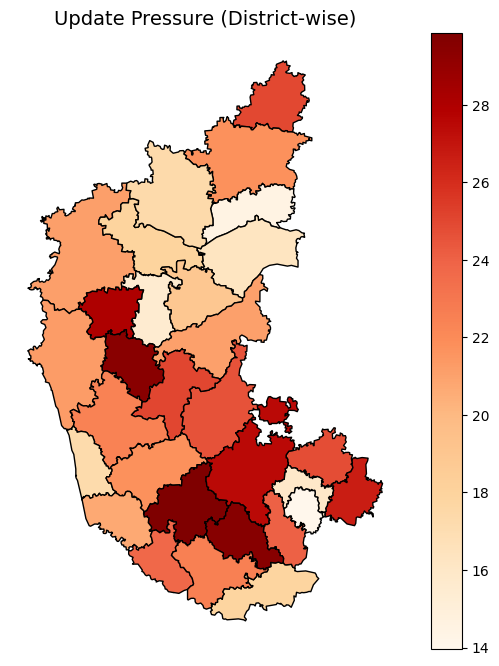

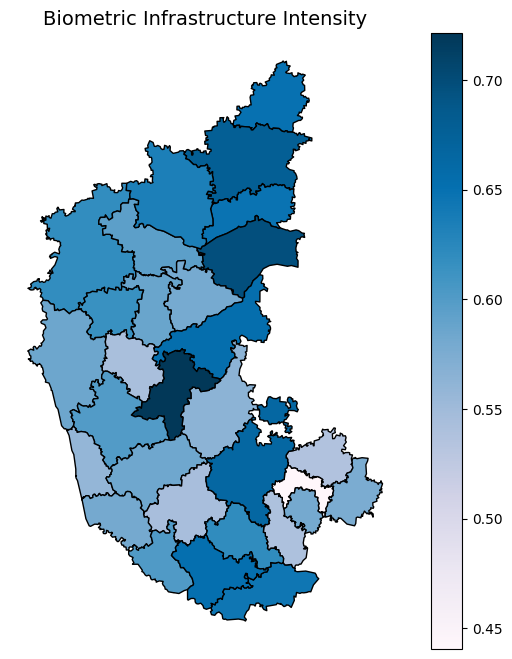

In [ ]:
# merge metrics with geodata
ka_geo_metrics = ka_geo.merge(
    district_wide,
    left_on="district_norm",
    right_on="district_matched",
    how="left"
)

# visualizations
plot_choropleth(ka_geo_metrics, "update_pressure", "Update Pressure (District-wise)", "OrRd")
plot_choropleth(ka_geo_metrics, "biometric_infra_intensity", "Biometric Infrastructure Intensity", "PuBu")

In [8]:
# Outlier detection using IQR method (more robust than z-score for smaller samples)
q1 = district_wide["update_pressure"].quantile(0.25)
q3 = district_wide["update_pressure"].quantile(0.75)
iqr = q3 - q1

district_wide["high_pressure_outlier"] = (
    district_wide["update_pressure"] > (q3 + 1.5 * iqr)
)

outliers = district_wide[district_wide["high_pressure_outlier"]]
print(f"High-pressure outlier districts: {len(outliers)}")
if len(outliers) > 0:
    print(outliers[["district_matched", "update_pressure"]])
else:
    print("No outliers found - Karnataka districts have relatively uniform update patterns!")

High-pressure outlier districts: 0
No outliers found - Karnataka districts have relatively uniform update patterns!
